In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score 
import seaborn as sns 
from sklearn.metrics import accuracy_score,mean_squared_error,classification_report,confusion_matrix,precision_score,recall_score,roc_curve,auc 
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn.neighbors import KNeighborsClassifier

# Reading & Exploring Health Care Dataset|

In [13]:
data = pd.read_excel("health care diabetes.xlsx")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
# checking no. of rows & columns of dataset
data.shape

(768, 9)

In [15]:
# Dataset Information Overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [16]:
# Summary Statistics for Diabetes Dataset
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Data Preprocessing : Treating the Missing Values

### In this dataset , 0 represents null values, and hence we will replace 0 by mean of their feature (variable ) columns.

In [17]:
#Identifying the mean of the features 
print(data['Glucose'].mean()) 
print(data['BloodPressure'].mean()) 
print(data['SkinThickness'].mean()) 
print(data['Insulin'].mean())

120.89453125
69.10546875
20.536458333333332
79.79947916666667


In [18]:
# Finding the number of rows which has the null values
print('Glucose-',len(data['Glucose'][data['Glucose']==0])) 
print('BloodPressure-',len(data['BloodPressure'][data['BloodPressure']==0])) 
print('SkinThickness-',len(data['SkinThickness'][data['SkinThickness']==0])) 
print('Insulin-',len(data['Insulin'][data['Insulin']==0]))

Glucose- 5
BloodPressure- 35
SkinThickness- 227
Insulin- 374


In [19]:
# Finding the null value percentage
selected_columns = ['Glucose', 'BloodPressure', 'SkinThickness','Insulin'] 
null_percentage = (data[selected_columns] == 0).mean() * 100 
# Displaying the null value percentage for each selected column 
print("Percentage of Null Values for Each Column:") 
print(null_percentage)

Percentage of Null Values for Each Column:
Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
dtype: float64


In [20]:
# Replacing the null values with the mean
data['Glucose']=data['Glucose'].replace([0],[data['Glucose'].mean()]) 
data['BloodPressure']=data['BloodPressure'].replace([0],[data['BloodPressure'].mean()]) 
data['SkinThickness']=data['SkinThickness'].replace([0],[data['SkinThickness'].mean()]) 
data['Insulin']=data['Insulin'].replace([0],[data['Insulin'].mean()])

In [21]:
#Checking the null value percentage of the treated columns 
null_percentage_treated = (data[selected_columns] == 0).mean() * 100 
# Displaying the null value percentage for each selected column 
print("Percentage of Null Values for Each Column after the null value treatment:") 
print(null_percentage_treated)

Percentage of Null Values for Each Column after the null value treatment:
Glucose          0.0
BloodPressure    0.0
SkinThickness    0.0
Insulin          0.0
dtype: float64


# Detecting Outliers and Treatment

In [22]:
columns=data[selected_columns]

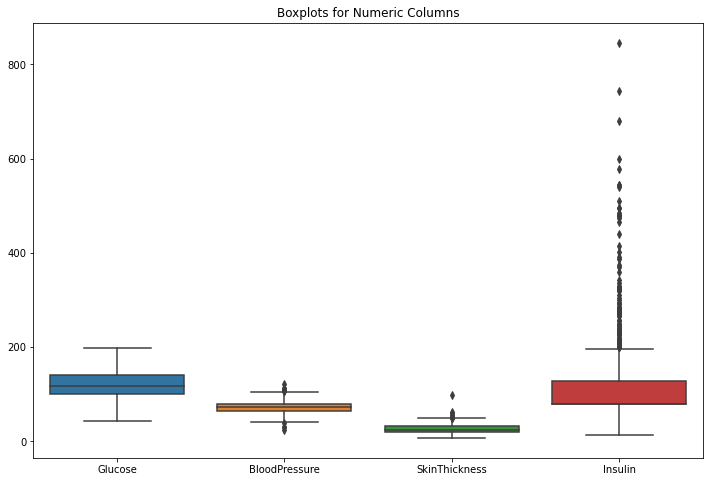

In [23]:
# Display boxplots for numeric columns to visualize outliers 
plt.figure(figsize=(12, 8)) 
sns.boxplot(data=columns) 
plt.title("Boxplots for Numeric Columns") 
plt.show()

In [24]:
# Finding the Outlier Count in the selected Columns: 
def find_outliers_iqr(data, column_name): 
    # Calculate the first quartile (Q1) and third quartile (Q3) 
    Q1 = data[column_name].quantile(0.25) 
    Q3 = data[column_name].quantile(0.75) 
    
    # Calculate the interquartile range (IQR) 
    IQR = Q3 - Q1 
    
    # Define the lower and upper bounds for outliers 
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR 
    
    # Find outliers 
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)] 
    
    # Count the number of outliers 
    count_outliers = len(outliers) 
    
    return count_outliers 

# Calculate and print the number of outliers for each column of interest 
for column_name in selected_columns: 
    outlier_count = find_outliers_iqr(data, column_name) 
    print(f"Number of outliers in the '{column_name}' column: {outlier_count}")

Number of outliers in the 'Glucose' column: 0
Number of outliers in the 'BloodPressure' column: 14
Number of outliers in the 'SkinThickness' column: 12
Number of outliers in the 'Insulin' column: 89
